In [1]:
import pandas as pd
import json
import os
from datetime import datetime, timedelta
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from IPython.display import Markdown, display
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
from IPython.display import display, Markdown
from IPython.display import Javascript

confidence_threshold = 0.8
#display options
N_occurrence_threshold_annual = 50
N_occurrence_threshold_daily = 100
date_tick = 5
cluster_name = "Vieux Salins"  #Cap Lardier , Porquerolles, Port-Cros,   param=20,50 , Vieux Salins ,  Salins des Pesquiers

database_path = f"merged_predictions_light/country=France"

multilingual_key = pd.read_csv('TABMON_MULTILINGUAL_KEY.csv') 
multilingual_key_dict = multilingual_key.set_index('Scientific_Name')['French_ioc'].to_dict()
#multilingual_key_dict = multilingual_key.set_index('Scientific_Name')['English_ioc'].to_dict()

multilingual_key_dict.update( {'Clamator glandarius' : 'Coucou geai' , 'Gyps fulvus' : "Vautour fauve", "Myiopsitta monachus" : "Conure veuve", "Aix sponsa": " Canard branchu", "Ixobrychus minutus" : "Blongios nain" , "Accipiter gentilis" : "Autour des palombes", "Alopochen aegyptiaca" : "Ouette d'Égypte" , "Charadrius alexandrinus" : "Gravelot à collier interrompu", "Falco naumanni" : "Faucon crécerellette" , "Chroicocephalus genei": "Goéland railleur" , "Pyrrhocorax graculus" : "Chocard à bec jaune" , "Alectoris rufa" : "Perdrix rouge", "Carduelis citrinella" : "Venturon montagnard" , "Porphyrio porphyrio" : "Talève sultane" , "Tetrax tetrax" : "Outarde canepetière" , "Apus pallidus" : "Martinet pâle" , "Cecropis daurica" : "Hirondelle rousseline" , "Callipepla californica": "Colin de Californie", "Coracias garrulus" : "Rollier d'Europe" , "Calonectris diomedea" : "Puffin de Scopoli" , "Alectoris chukar" : "Perdrix choukar" , "Acrocephalus melanopogon" : "Lusciniole à moustaches" , "Charadrius morinellus" : "Guignard d'Eurasie" , "Curruca iberiae" : "Fauvette passerinette" , "Curruca conspicillata" : "Fauvette à lunettes" , "Sinosuthora webbiana" : "Paradoxornis de Webb" } )


site_info = pd.read_csv('site_info.csv') 

plot_width = 12
plt.rcParams.update({'font.size': 6})
plt.rcParams["figure.dpi"] = 150 

display(Markdown(f"<h1> Rapport TABMON :  {cluster_name} "))



<h1> Rapport TABMON :  Vieux Salins 

In [2]:


deploymentID_list = site_info[site_info["Cluster"]==cluster_name]["DeploymentID"].tolist()
bugg_id_list = site_info[site_info["Cluster"]==cluster_name]["DeviceID"].tolist()
site_list = site_info[site_info["Cluster"]==cluster_name]["Site"].tolist()
deployment_date_list = site_info[site_info["Cluster"]==cluster_name]["deploymentBeginDate"]

indexes = [bugg_id_list.index(x) for x in set(bugg_id_list)]
bugg_id_list =  [bugg_id_list[id] for id in indexes]
site_list =  [site_list[id] for id in indexes]
#print(deploymentID_list)
#print(bugg_id_list)
#print(site_list)
#print(deployment_date_list)
deployment_date_list = [ datetime.strptime(f"{date}", "%d/%m/%Y") for date in deployment_date_list]


In [3]:
species_filter = ["Porzana porzana","Tetrao urogallus"]


file_path_list = []
for bugg_id in bugg_id_list:
    bugg_path = os.path.join(database_path, f"device_id={bugg_id}")
    bugg_files = sorted(os.listdir(bugg_path))

    file_path_list.append([os.path.join(bugg_path, file) for file in bugg_files])



def parse_date(date_str):
    formats = [
        "%Y-%m-%dT%H:%M:%S.%fZ",
        "%Y-%m-%dT%H:%M:%SZ",
        "%Y-%m-%dT%H:%MZ"
    ]
    for fmt in formats:
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    raise ValueError(f"Date format not supported: {date_str}")


def get_file_date(bugg_file_name):
    date = bugg_file_name.replace('.mp3', '')
    date = date.replace('_', ':')
    date = parse_date(date)
    return date.date()


def get_file_time(bugg_file_name):
    date = bugg_file_name.replace('.mp3', '')
    date = date.replace('_', ':')
    date = parse_date(date)
    return date.hour

def get_bugg_id(folder_name):
    part = folder_name.split('-', 1)[1]
    part = part[1:]
    part = part.lstrip('0')
    return part


def load_parquet(file_path):  
    predictions_df = pd.read_parquet(file_path, engine='pyarrow') 
    #predictions_df = predictions_df.drop('energy', axis=1)
    #predictions_df = predictions_df.drop('model', axis=1)
    #predictions_df = predictions_df.drop('model_checkpoint', axis=1)
    #predictions_df = predictions_df.drop('datetime', axis=1)
    #predictions_df = predictions_df.drop('lat', axis=1)
    #predictions_df= predictions_df.drop('lng', axis=1)

    predictions_df = predictions_df[predictions_df["confidence"] > confidence_threshold]

    for species in species_filter:
        predictions_df = predictions_df[predictions_df["scientific name"] != species]

    predictions_df['date'] = predictions_df['filename'].apply(get_file_date)
    predictions_df['time'] = predictions_df['filename'].apply(get_file_time)


    return predictions_df



# Activité des enregistreurs
Les microphones enregistrent l'activité acoustique 24h/24 par fichier de 5 min et les envoient par 4G.
La figure suivante présente le nombre d'enregistrements reçus par jour pour chaque enregistreur de la zone.
En fonctionnement normal, nous devons recevoir 288 fichiers par enregistreurs par jour (ligne verte).
Le manque d'enregistrement est le plus souvent dû à une mauvaise connexion sur la zone, mais peut aussi venir de problèmes d'alimentation (panneau solaire ou batterie) ou de dysfonctionnements internes du microphone.


In [4]:
index_path = "index.parquet"
index_df = pd.read_parquet(index_path, engine='pyarrow')
index_df = index_df[index_df["MimeType"]=='audio/mpeg']
index_df = index_df[list(map(lambda x: x.startswith('bugg_RPiID'), index_df['device']))]
index_df["date"] = index_df.apply(lambda row: get_file_date(row['Name']), axis=1)
index_df = index_df[["date", "Name", "device"]]
index_df["bugg_id"] = index_df.apply(lambda row: get_bugg_id(row['device']), axis=1)

#print(index_df["bugg_id"].unique())

index_df = index_df[index_df["bugg_id"].isin(bugg_id_list)]

#print(index_df["bugg_id"].unique())



full_date_range = pd.date_range(
    #start=index_df['date'].min(),
    #start="2025-05-01",
    start = min(deployment_date_list),
    end=index_df['date'].max(),
    freq='D'  # daily
).date 


/tmp/ipykernel_2939426/2607700197.py:29: RuntimeWarning: '<' not supported between instances of 'datetime.date' and 'int', sort order is undefined for incomparable objects.
  date_counts_total = date_counts_total.add(date_counts, fill_value=0);
/tmp/ipykernel_2939426/2607700197.py:29: RuntimeWarning: '<' not supported between instances of 'datetime.date' and 'int', sort order is undefined for incomparable objects.
  date_counts_total = date_counts_total.add(date_counts, fill_value=0);


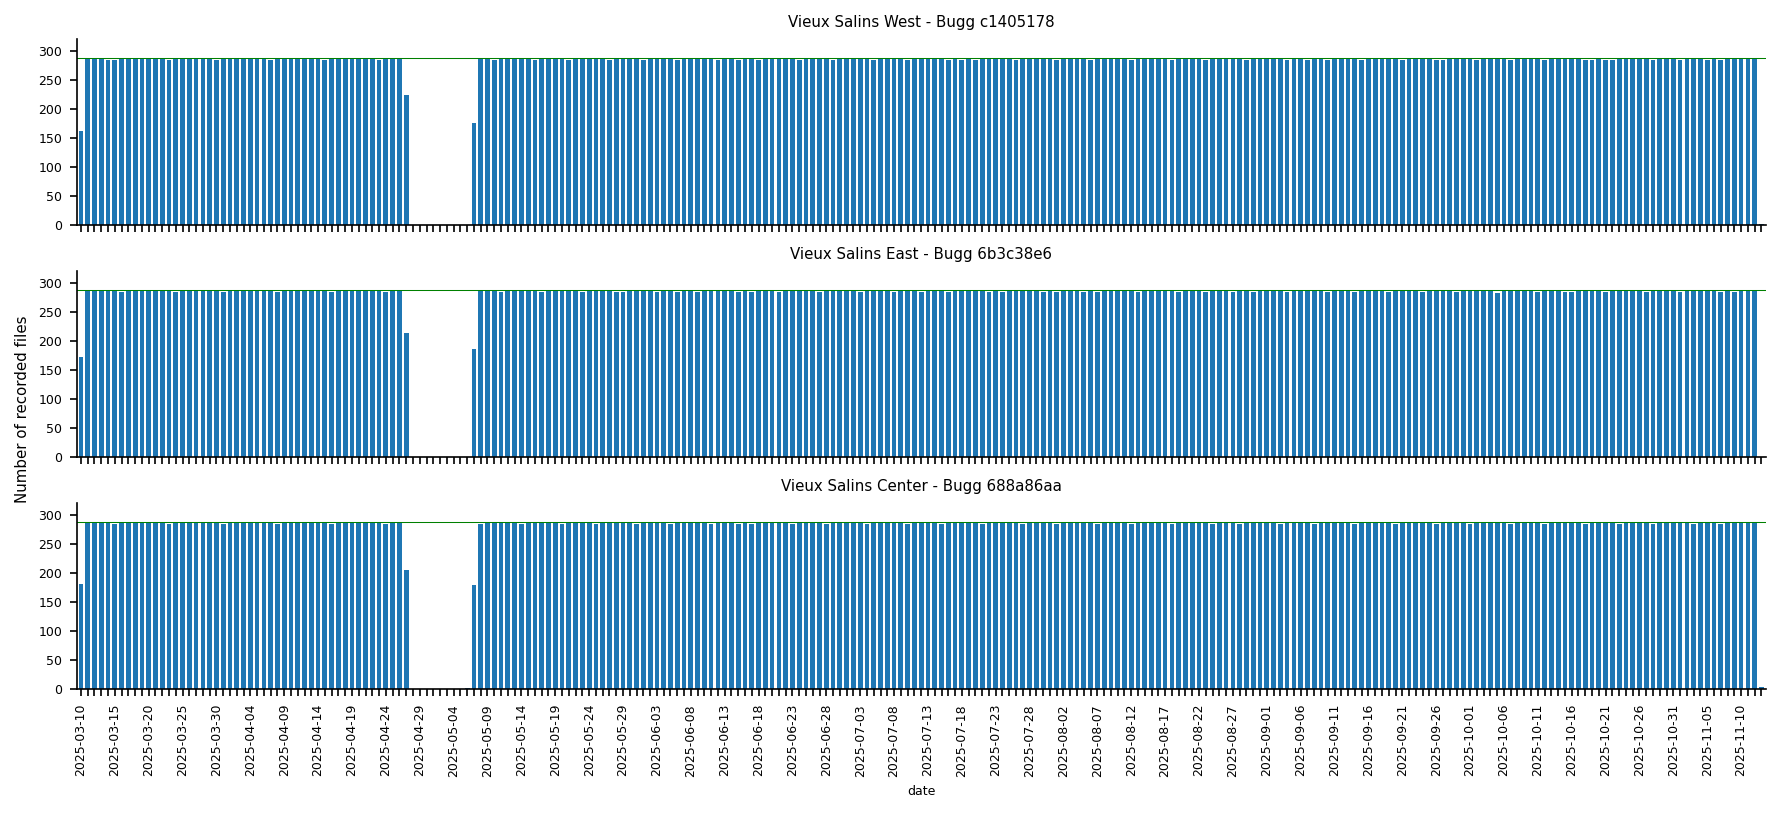

In [5]:


N_plot = len(bugg_id_list)
fig, ax = plt.subplots(N_plot,1, figsize=(plot_width , 1.8*N_plot), sharex=True )

fig.supylabel("Number of recorded files \n")


date_counts_total = pd.Series(0, dtype=int)  # Initialize an empty Series for accumulation

for i, bugg_id in enumerate(bugg_id_list):

    ax[i].set_title( f"{site_list[i]} - Bugg {bugg_id}")
    date_counts = index_df['date'][index_df["device"].str.endswith(bugg_id)].value_counts().sort_index()
    date_counts = date_counts.reindex(full_date_range, fill_value=0)

    date_counts.plot(kind='bar', ax=ax[i],width = 0.7)

    #ax[i].set_ylabel("Number of files")

    ax[i].axhline(y=288, color='g', linewidth=0.5)
    ax[i].set_ylim([0,320])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    xticks = ax[i].xaxis.get_major_ticks()

    for j,tick in enumerate(xticks):
        if j%date_tick != 0:
            tick.label1.set_visible(False)

    date_counts_total = date_counts_total.add(date_counts, fill_value=0);

plt.tight_layout()



In [6]:

predictions_df = [ load_parquet(file_path) for file_path in file_path_list]
predictions_df = pd.concat(predictions_df, ignore_index=True)
N_tot = predictions_df.shape[0]
predictions_df['common name'] = predictions_df['scientific name'].map(multilingual_key_dict)

if predictions_df['common name'].isnull().sum() > 0 :

    untranslated_species = list(set(predictions_df['scientific name'][predictions_df['common name'].isnull()].tolist()))

    print("Translation error", untranslated_species)
    
#print(predictions_df.columns)

analyzed_date_range = pd.date_range(
    #start=index_df['date'].min(),
    #start="2025-05-01",
    start = min(deployment_date_list),
    end=predictions_df['date'].max(),
    freq='D'  # daily
).date 


# Espèces détectées


In [7]:
display(Markdown(f"Nous utilisons pour l'instant BirdNET pour détecter les espèces d'oiseaux présentes sur les enregistrements. Les enregistrements sont divisés en segments de 3 secondes avant d'être analysés. Pour chaque segment, BirdNET fournit un score de confiance compris entre 0 et 1 à chaque espèce. Les figures suivantes présentent le nombre de détections par espèce dont le score de confiance est supérieur à {confidence_threshold}."))


Nous utilisons pour l'instant BirdNET pour détecter les espèces d'oiseaux présentes sur les enregistrements. Les enregistrements sont divisés en segments de 3 secondes avant d'être analysés. Pour chaque segment, BirdNET fournit un score de confiance compris entre 0 et 1 à chaque espèce. Les figures suivantes présentent le nombre de détections par espèce dont le score de confiance est supérieur à 0.8.


Le nombre de détections correspond au nombre de segments de 3 secondes dans lequel l'espèce est détectée.
Le graphique suivant présente le nombre de détections par espèce sur la zone sur toute la période. 
Il est à noter que dans l'ensemble du document le nombre de détections est affiché selon une échelle avec une graduation logarithmique.
Ces données doivent être considérées avec prudence, en particulier pour les espèces qui n'ont été détectées qu'à quelques reprises. Il s'agit des résultats bruts fournis par BirdNET, qui n'ont pas été vérifiés manuellement. De plus, les performances de BirdNET peuvent varier fortement d'une espèce à l'autre. 

In [8]:
"""n_species = predictions_df['common name'].value_counts().shape[0]


# Create figure and axis
fig, ax = plt.subplots(figsize=(plot_width-4 , int(n_species/12)))

# Plot using the specific axis
predictions_df['common name'].value_counts().plot(kind='barh', ax=ax)

# Set x-axis to logarithmic scale
ax.set_xscale('log')

# Disable scientific notation on x-axis
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
# Optional: add labels and title
ax.set_xlabel("Number of detections (logarithmic scale)")
ax.set_ylabel("")

#ax.set_title(f"Number of detections per species - {cluster_name}")
ax.xaxis.grid()# Show plot
ax.invert_yaxis()  # This flips the chart upside down
plt.tight_layout()""";


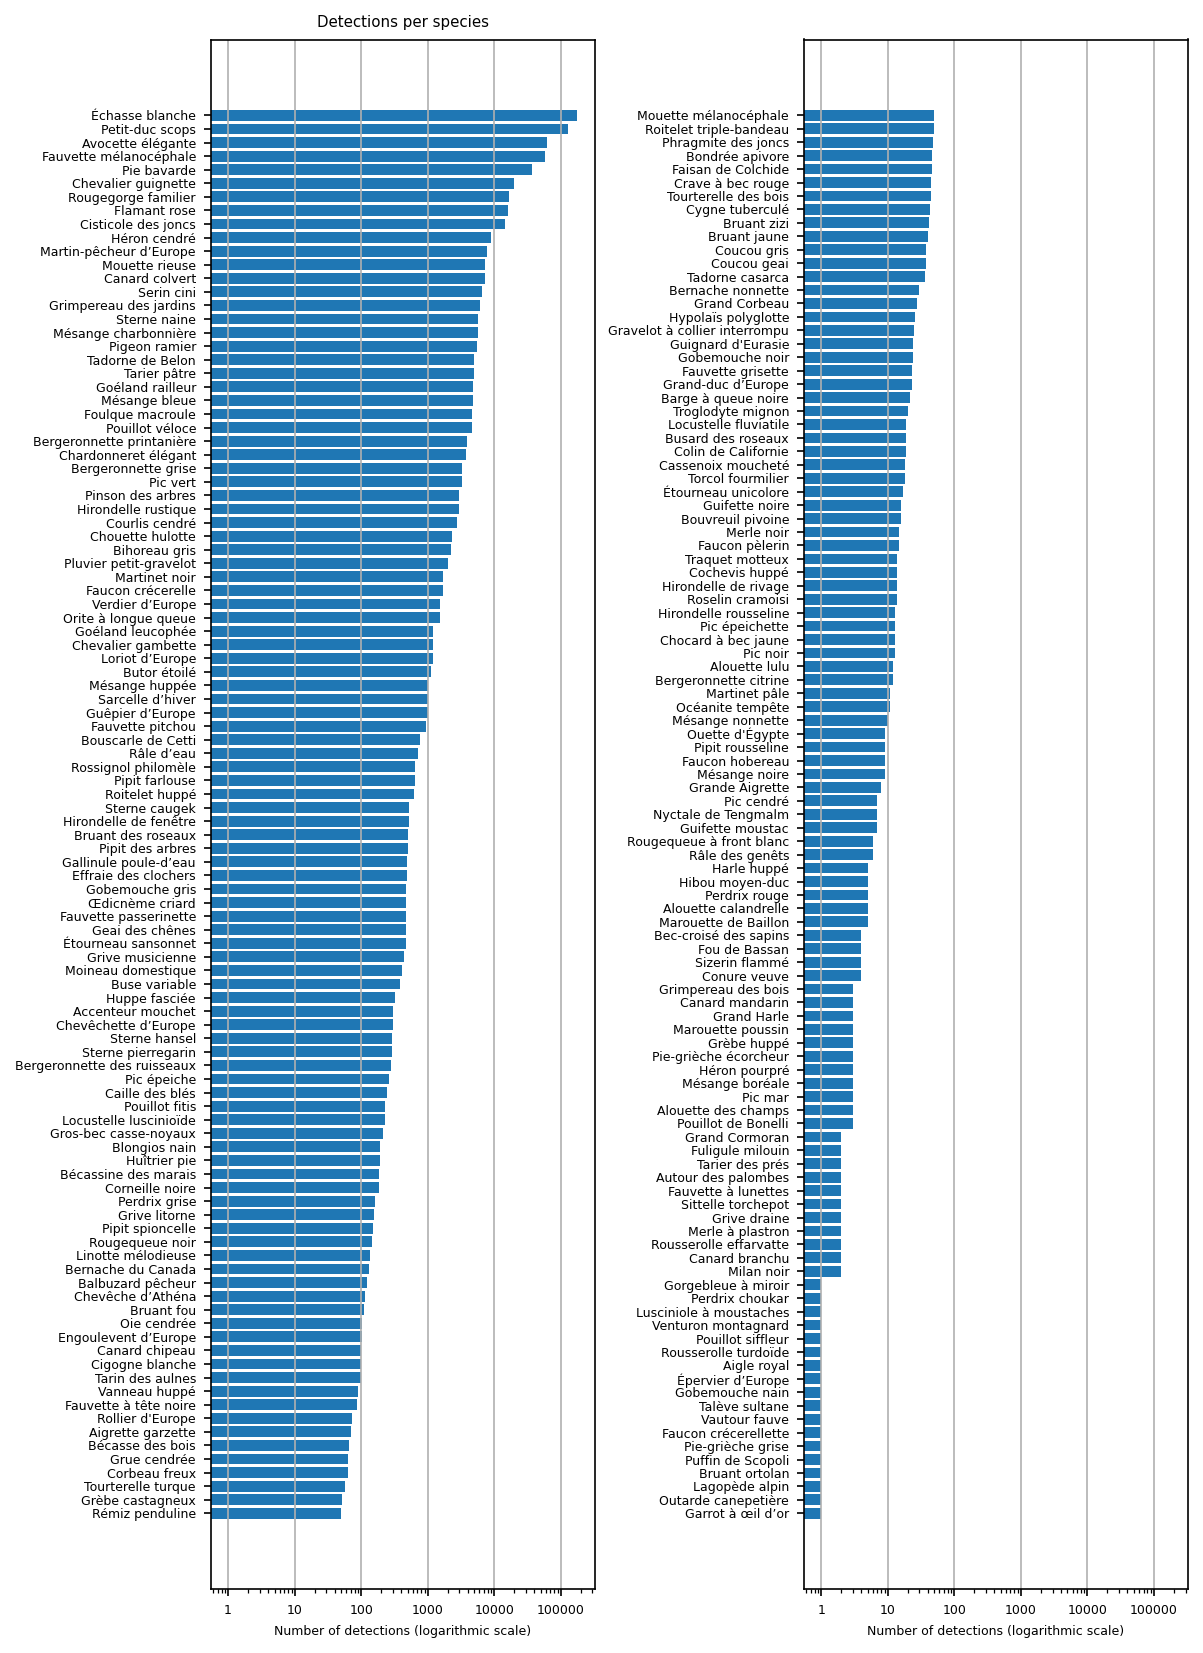

In [9]:
counts = predictions_df['common name'].value_counts()
n_species = len(counts)
# Split indexes into two halves
mid = n_species // 2
top_half = counts.iloc[:mid]
bottom_half = counts.iloc[mid:]

# Create double figure
fig, axes = plt.subplots(
    1, 2,
    figsize=(plot_width - 4, int(n_species / 18)),  # half height per plot
    sharex=True
)

axes[0].barh(top_half.index, top_half.values)
axes[0].set_xscale('log')
axes[0].invert_yaxis()
axes[0].set_ylabel("")
axes[0].set_title("Detections per species")

axes[1].barh(bottom_half.index, bottom_half.values)
axes[1].set_xscale('log')
axes[1].invert_yaxis()
axes[1].set_ylabel("")

formatter = ScalarFormatter()
formatter.set_scientific(False)
axes[1].xaxis.set_major_formatter(formatter)

axes[0].xaxis.grid(True)
axes[1].xaxis.grid(True)

axes[0].set_xlabel("Number of detections (logarithmic scale)")
axes[1].set_xlabel("Number of detections (logarithmic scale)")

plt.tight_layout()

---
\newpage
---

# Evolution journalière


In [10]:
display(Markdown(f"La figure suivante montre l'activité journalière de chaque espèce, en indiquant le nombre de détections par tranche horaire. Seules les espèces avec plus de {N_occurrence_threshold_daily} détections au total sont affichées. Il est à noter que l'heure indiquée est l'heure UTC, qui a deux heures de retard sur notre heure d'été et une heure de retard sur notre heure d'hiver (ex. : 12h UTC = 14h en été)."))


La figure suivante montre l'activité journalière de chaque espèce, en indiquant le nombre de détections par tranche horaire. Seules les espèces avec plus de 100 détections au total sont affichées. Il est à noter que l'heure indiquée est l'heure UTC, qui a deux heures de retard sur notre heure d'été et une heure de retard sur notre heure d'hiver (ex. : 12h UTC = 14h en été).

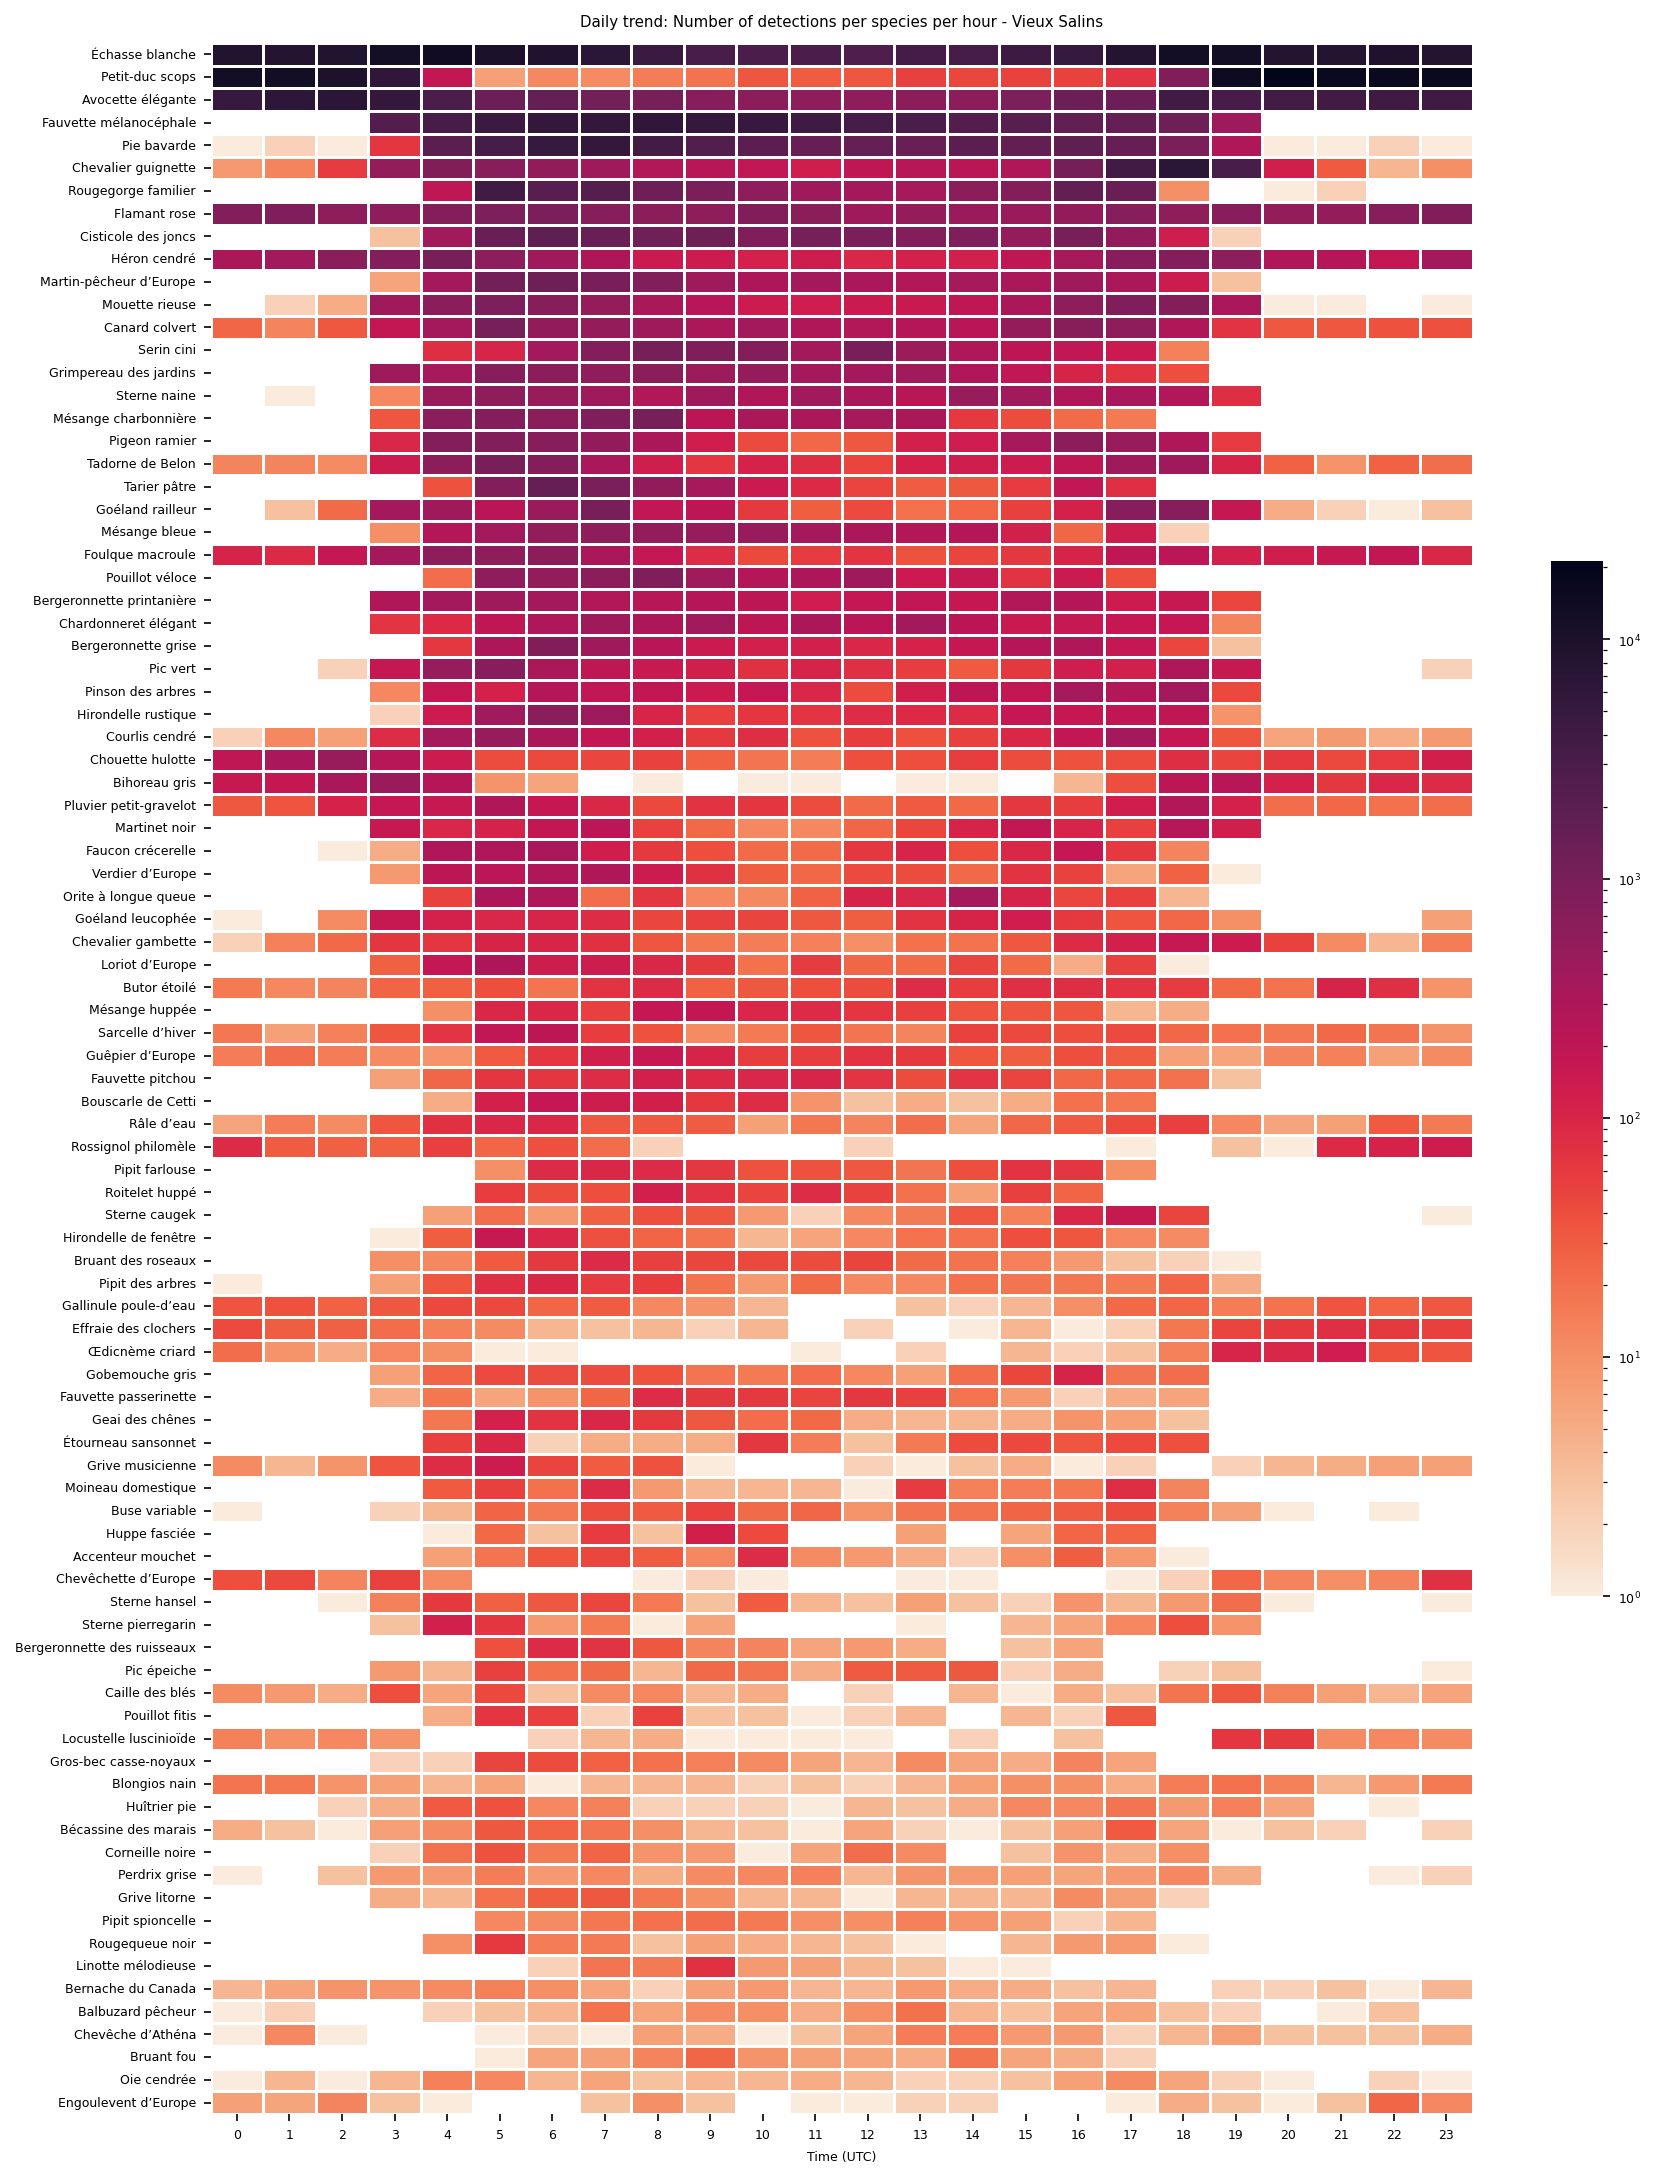

In [11]:
grouped_df = predictions_df.groupby(['time', 'common name']).size().unstack(fill_value=0)
grouped_df = grouped_df.sort_index() # Sort by date 

grouped_df = grouped_df.loc[:,grouped_df.sum()>N_occurrence_threshold_daily] #keep species with more than 10 occurrence

species_order = grouped_df.sum().sort_values(ascending=False).index.tolist()
grouped_df = grouped_df[species_order]

n_species = grouped_df.shape[1]


fig, ax = plt.subplots(figsize=(plot_width, 1.5 + n_species/7))

cmap = sns.cm.rocket_r

sns.heatmap(grouped_df.T, norm=LogNorm(), cmap = cmap, cbar_kws={"shrink": 0.5}, linewidth=.5)
ax.set_title(f"Daily trend: Number of detections per species per hour - {cluster_name}",  y=1.002 )
ax.set_ylabel("")
ax.set_xlabel("Time (UTC)")

plt.tight_layout()



---
\newpage
---

# Evolution annuelle


In [12]:
display(Markdown(f"La figure suivante montre l'évolution des détections jour après jour. Seules les espèces avec plus de {N_occurrence_threshold_annual} détections au total sont affichées."))


La figure suivante montre l'évolution des détections jour après jour. Seules les espèces avec plus de 50 détections au total sont affichées.

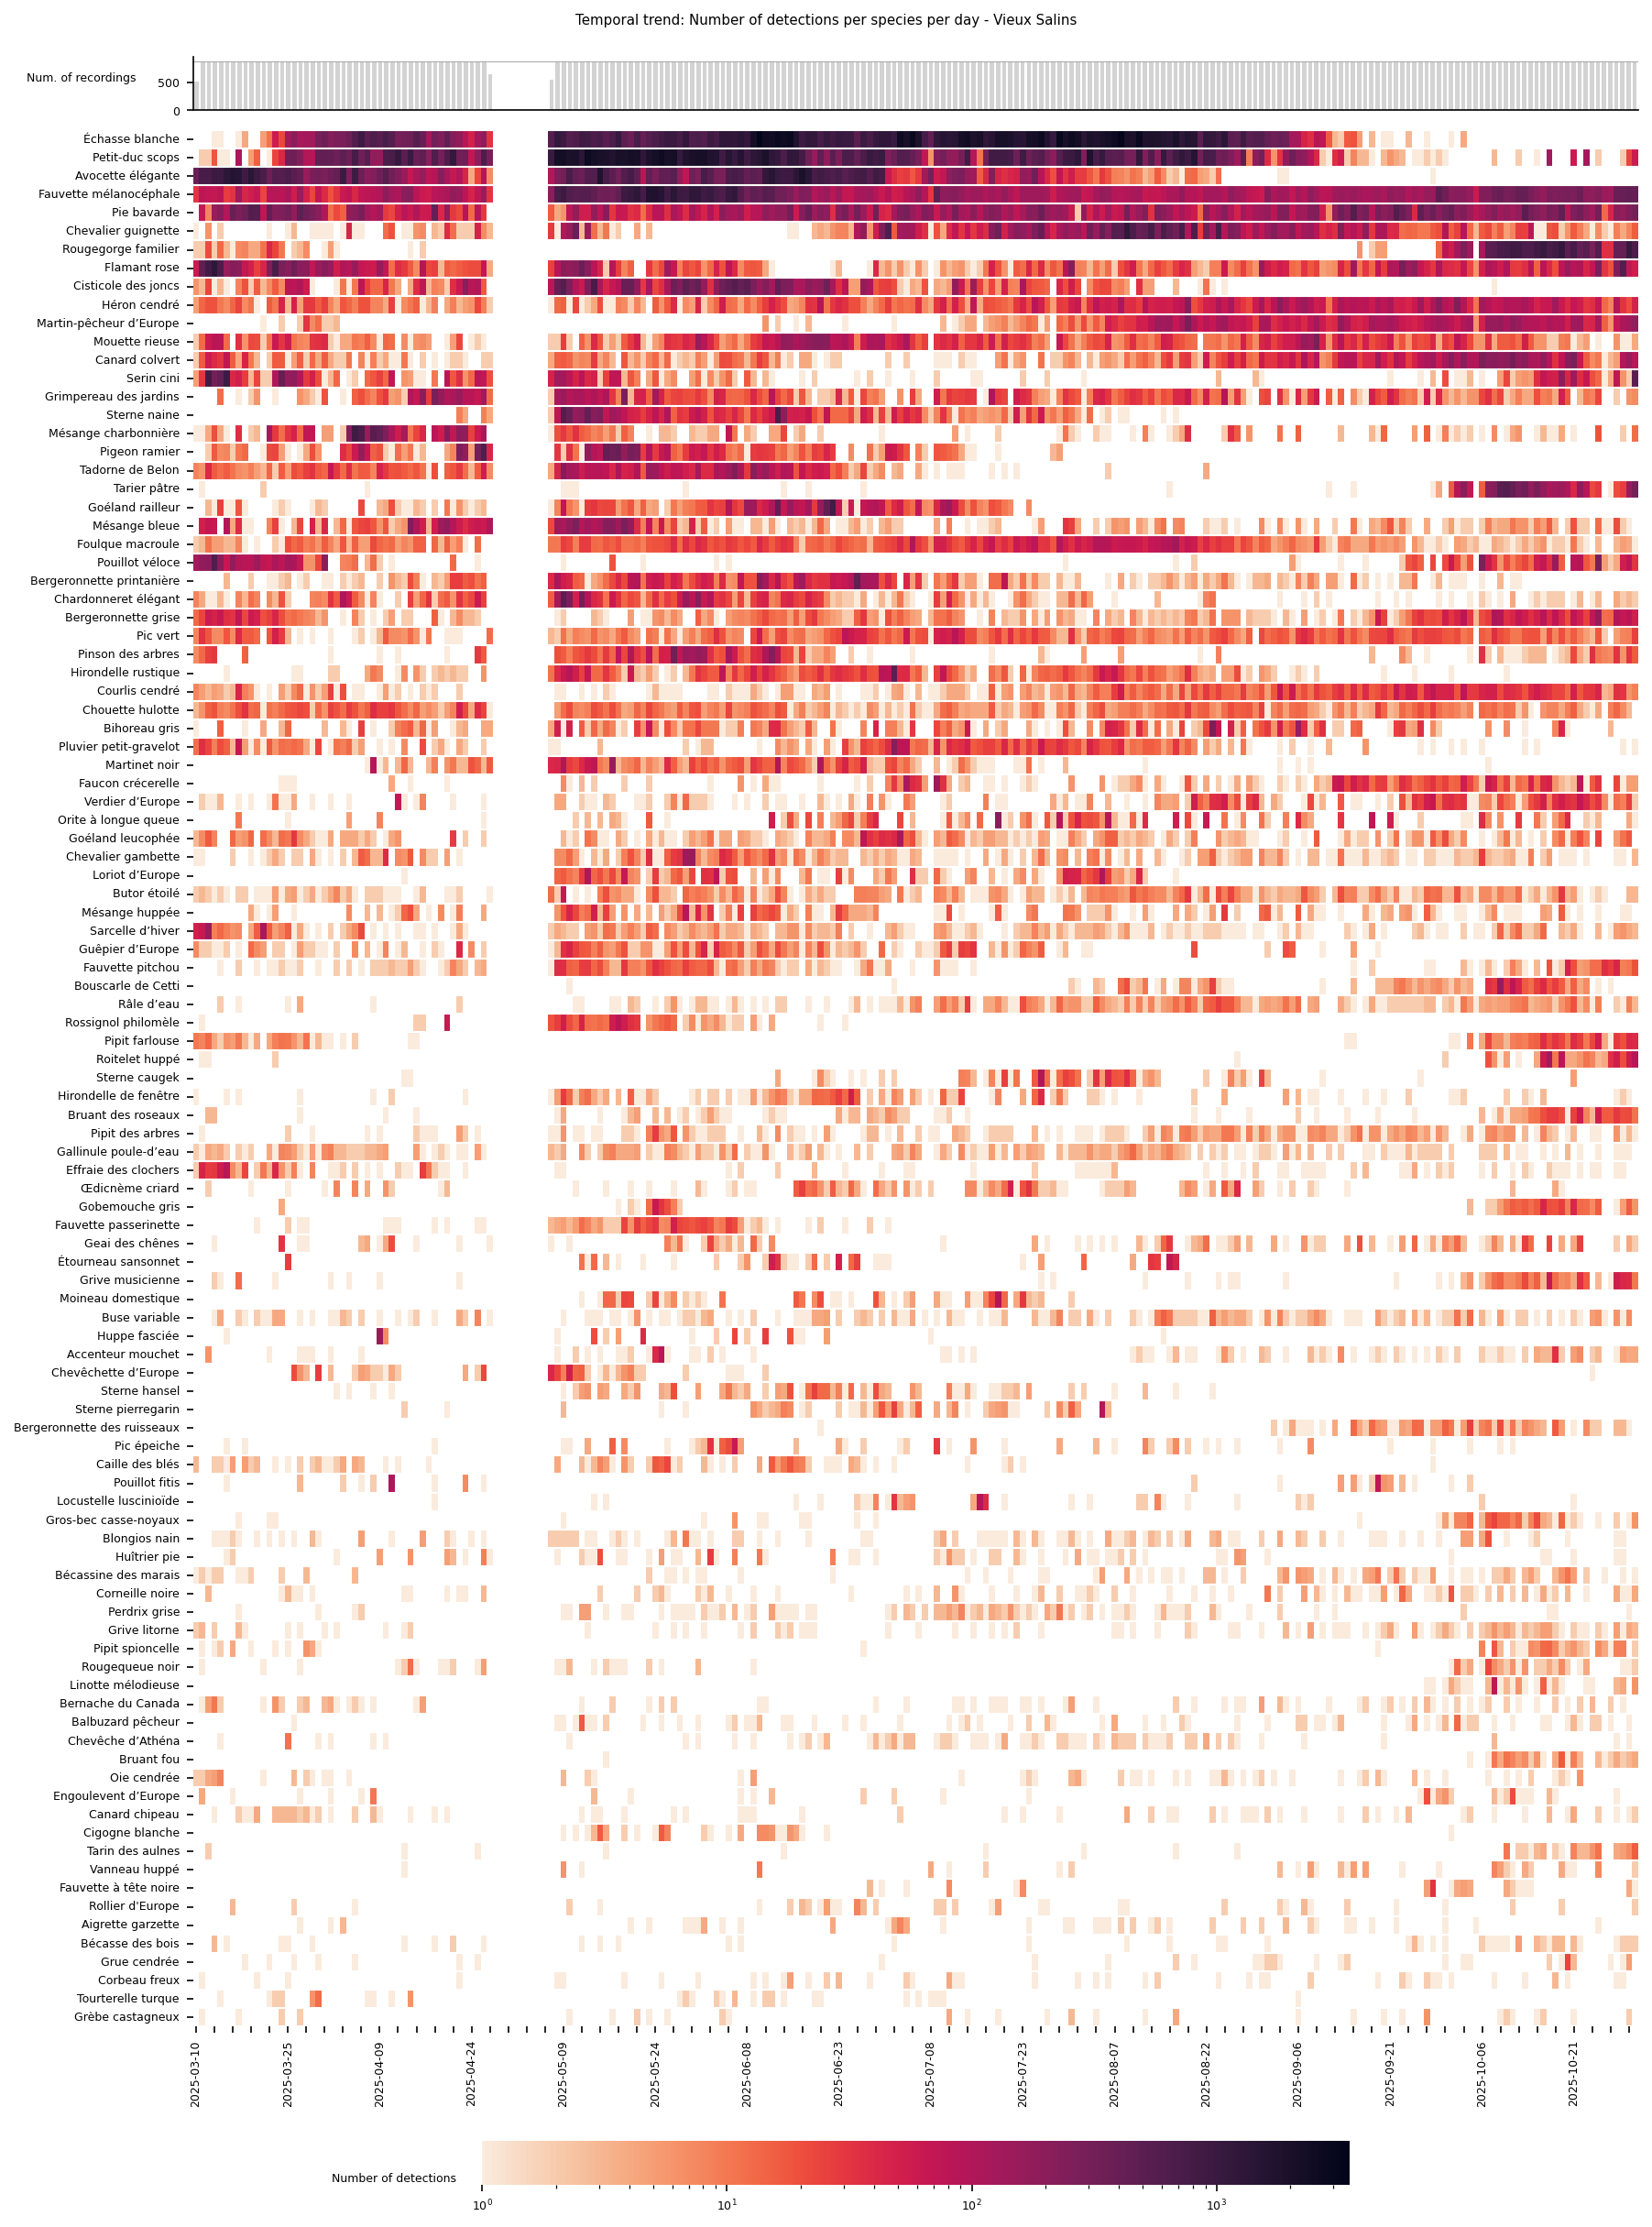

In [13]:

grouped_df = predictions_df.groupby(['date', 'common name']).size().unstack(fill_value=0)
grouped_df = grouped_df.sort_index() # Sort by date 
species_occurrence_filter = grouped_df.sum()>N_occurrence_threshold_annual
grouped_df = grouped_df.loc[:,species_occurrence_filter] #keep species with more than 10 occurrence

species_order = grouped_df.sum().sort_values(ascending=False).index.tolist()
grouped_df = grouped_df[species_order]
grouped_df = grouped_df.reindex(analyzed_date_range, fill_value=0)

#grouped_df.reindex(full_date_range, fill_value=0)

n_species = grouped_df.shape[1]


height1 = 0.4
height2 = 3 + n_species/7

fig, ax = plt.subplots(2,1,figsize=(plot_width, height1 + height2 ),  gridspec_kw={'height_ratios': [height1, height2]} )
fig.suptitle(f"Temporal trend: Number of detections per species per day - {cluster_name}",  y=1.002 )


date_counts_total = date_counts_total.reindex(analyzed_date_range, fill_value=0)
date_counts_total.plot(kind='bar', ax=ax[0],width = 0.7 , color="lightgrey")
n_files_max = 288*N_plot
ax[0].axhline(y=n_files_max, color='darkgrey', linewidth=0.5)
ax[0].set_ylim([0,n_files_max*1.1])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylabel("Num. of recordings", rotation=0, labelpad=40)

cmap = sns.cm.rocket_r
sns.heatmap(grouped_df.T, norm=LogNorm(), cmap = cmap, cbar_kws={"shrink": 0.6, 'orientation': 'horizontal', "pad": 5/n_species}, linewidth=0, ax=ax[1])


for i in range(grouped_df.shape[1]+1):
    ax[1].axhline(i, color='white', lw=1)
ax[1].set_ylabel("")
ax[1].set_xlabel("")

xticks = ax[1].xaxis.get_major_ticks()
for j,tick in enumerate(xticks):
    if j%date_tick != 0:
        tick.label1.set_visible(False)


fig.text(0.2, 0.13, "Number of detections", verticalalignment='bottom', horizontalalignment='left')


plt.tight_layout()


---
\newpage
---

# Détail par enregistreur

Ces mêmes données sont ici détaillées par enregistreur.

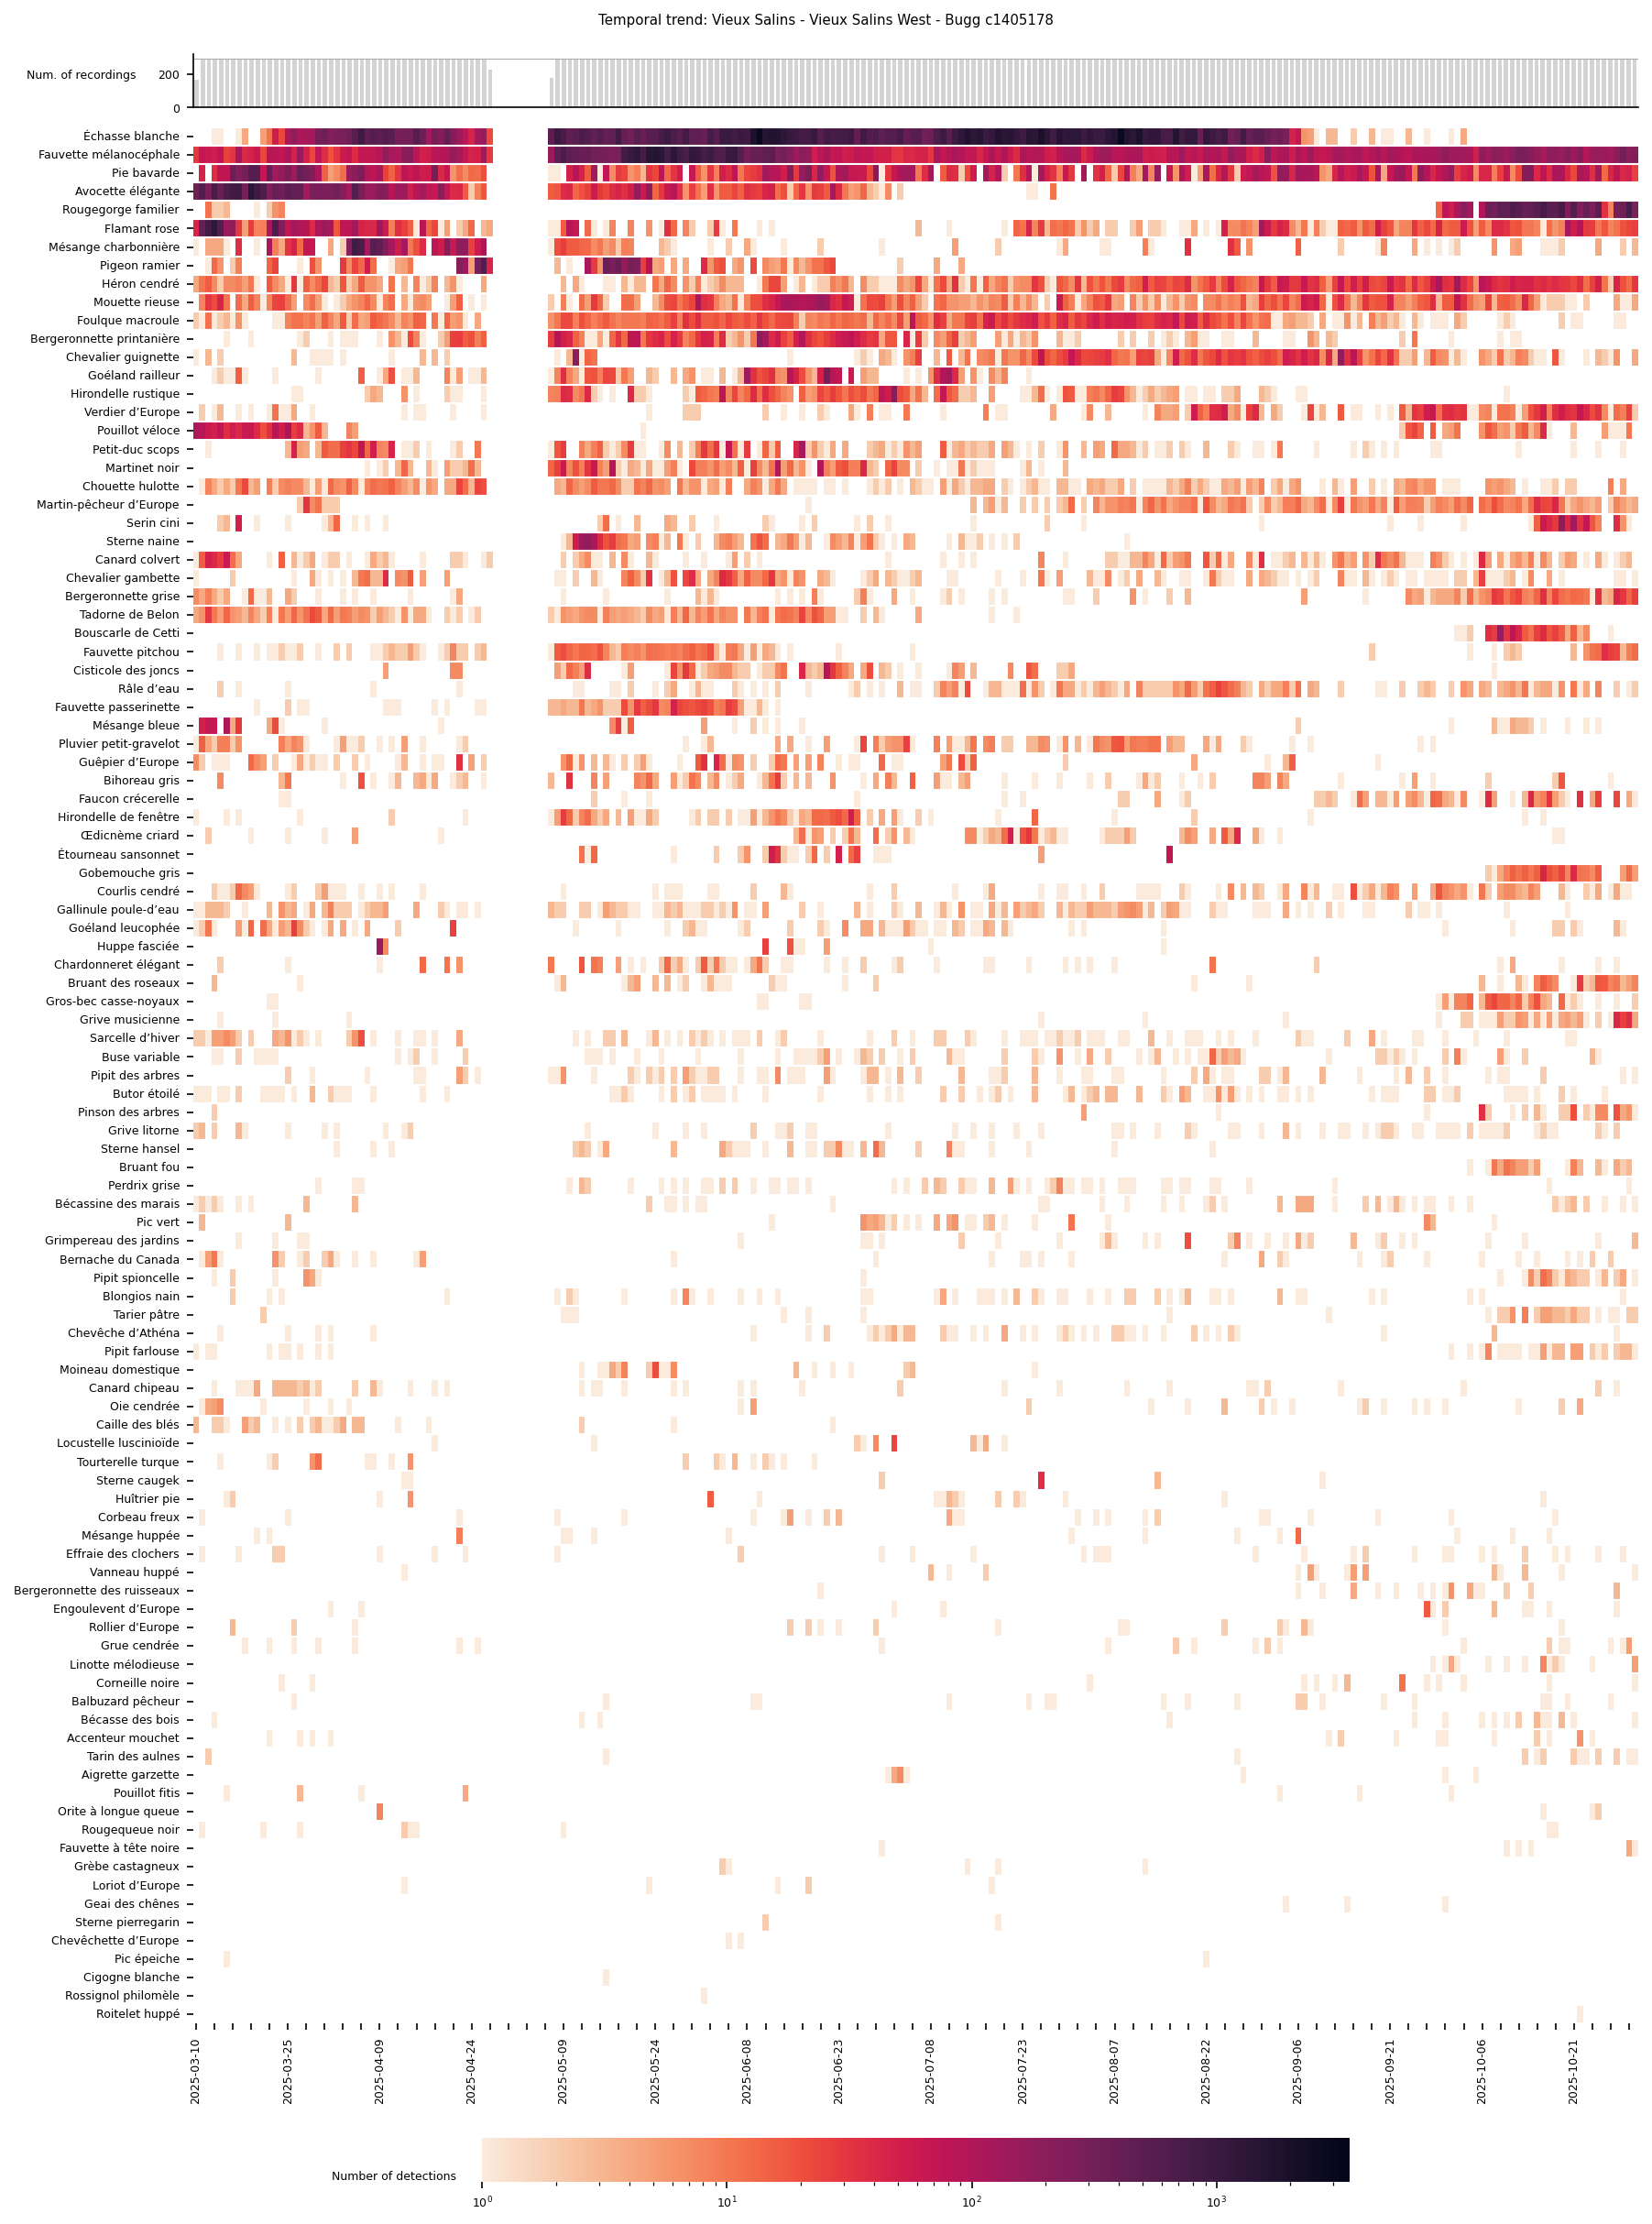

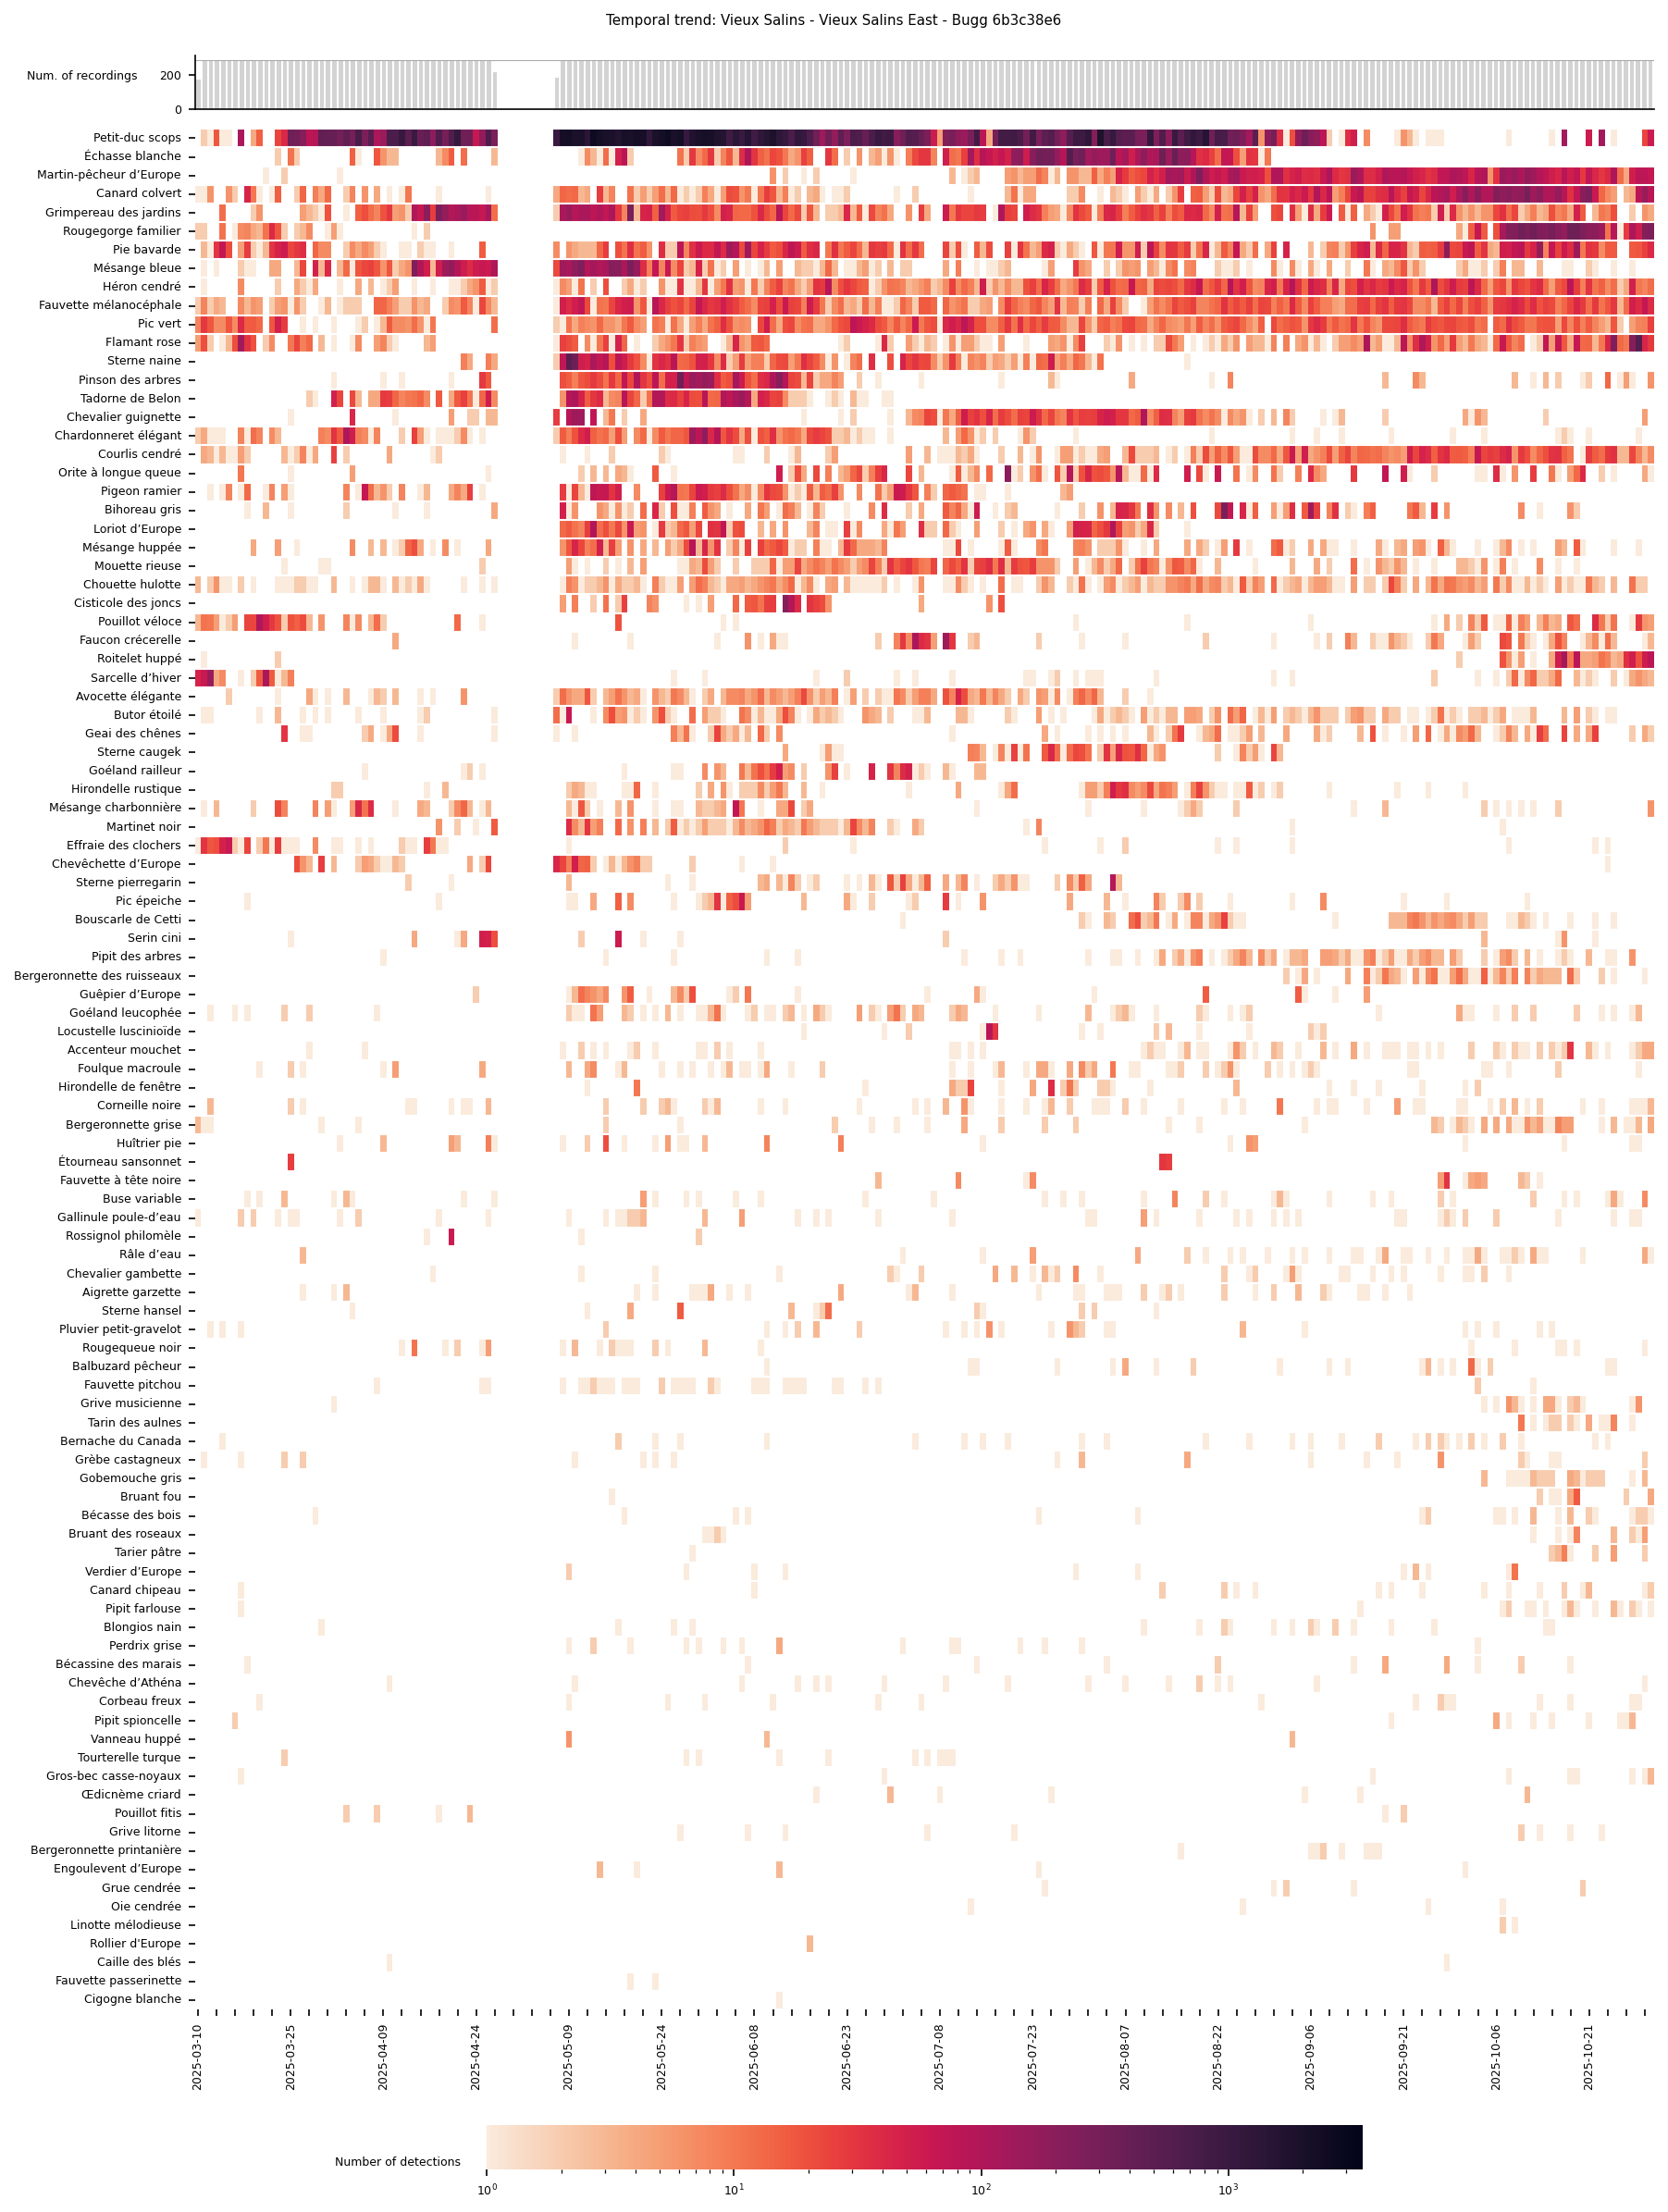

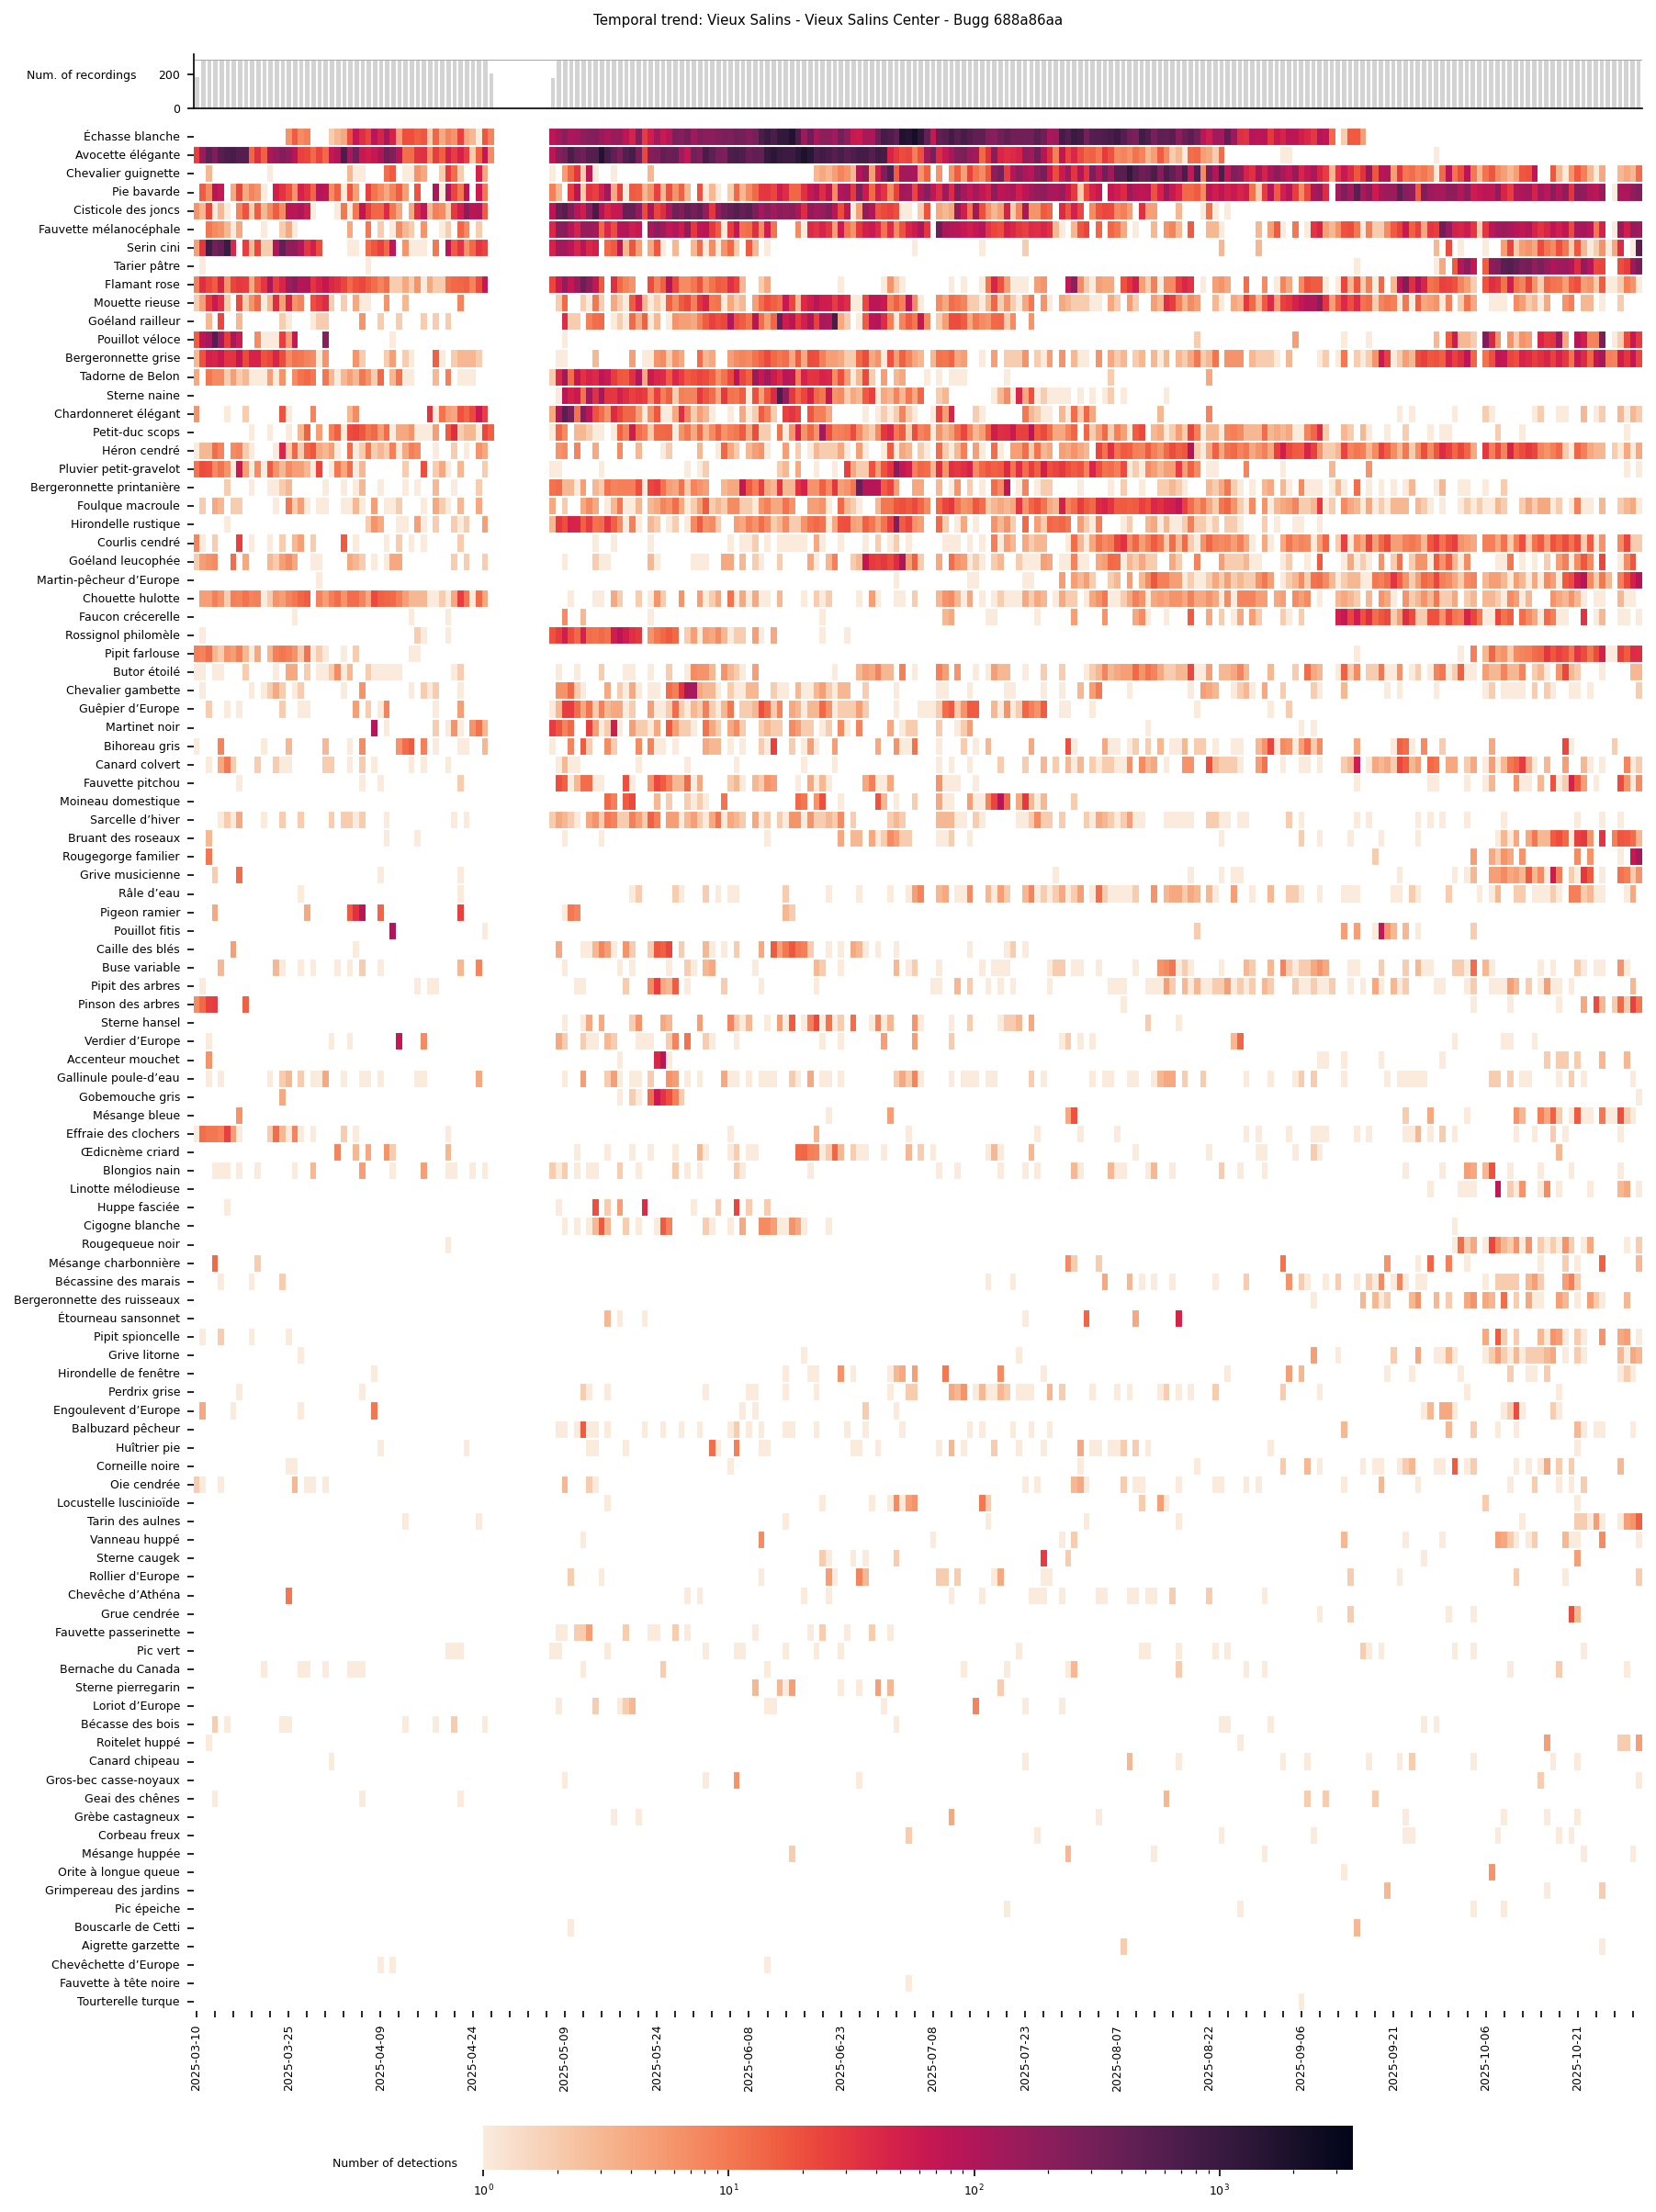

In [14]:

base_df = predictions_df.groupby(['date', 'common name']).size().unstack(fill_value=0)
vmax = base_df.to_numpy().max()
cmap = sns.cm.rocket_r


for i, bugg_id in enumerate(bugg_id_list):

    grouped_df  = predictions_df[predictions_df['device_id'] == bugg_id]
    grouped_df = grouped_df.groupby(['date', 'common name']).size().unstack(fill_value=0)
    grouped_df = grouped_df.sort_index() # Sort by date 
    
    #grouped_df = grouped_df.loc[:,grouped_df.sum()>N_occurrence_threshold_annual] #keep species with more than N occurrence
    grouped_df = grouped_df.loc[:,species_occurrence_filter] #keep species with more than N occurrence
    species_order = grouped_df.sum().sort_values(ascending=False).index.tolist()
    grouped_df = grouped_df[species_order]

    grouped_df = grouped_df.reindex(analyzed_date_range, fill_value=0)

    n_species = grouped_df.shape[1]

    height1 = 0.4
    height2 = 3 + n_species/7
    fig, ax = plt.subplots(2,1,figsize=(plot_width, height1 + height2 ),  gridspec_kw={'height_ratios': [height1, height2]} )
    fig.suptitle(f"Temporal trend: {cluster_name} - {site_list[i]} - Bugg {bugg_id}",   y=1.001)

    date_counts = index_df['date'][index_df["device"].str.endswith(bugg_id)].value_counts().sort_index()

    date_counts = date_counts.reindex(analyzed_date_range, fill_value=0)
    date_counts.plot(kind='bar', ax=ax[0], width = 0.7 , color="lightgrey")
    n_files_max = 288
    ax[0].axhline(y=n_files_max, color='darkgrey', linewidth=0.5)
    ax[0].set_ylim([0,n_files_max*1.1])
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].get_xaxis().set_visible(False)
    ax[0].set_ylabel("Num. of recordings", rotation=0, labelpad=40)



    sns.heatmap(grouped_df.T,cmap = cmap, cbar_kws={"shrink": 0.6, 'orientation': 'horizontal', "pad": 5/n_species}, linewidth=0, ax=ax[1], norm=(LogNorm(vmin=1, vmax=vmax)))

    for j in range(grouped_df.T[grouped_df.sum(axis=0) != 0].shape[1]+1):
        ax[1].axhline(j, color='white', lw=1)
    ax[1].set_ylabel("")
    ax[1].set_xlabel("")

    xticks = ax[1].xaxis.get_major_ticks()
    for j,tick in enumerate(xticks):
        if j%date_tick != 0:
            tick.label1.set_visible(False)

    fig.text(0.2, 0.13, "Number of detections", verticalalignment='bottom', horizontalalignment='left')
    plt.tight_layout()


In [15]:
import warnings
warnings.filterwarnings('ignore')
#os.system(f'jupyter nbconvert --execute --to pdf --no-input  --template custom_template.tplx --output "tabmon_report_{cluster_name}.pdf" "TABMON report.ipynb"')
import subprocess

subprocess.run(
    [
        "jupyter", "nbconvert",
        "--to", "pdf",
        "--no-input",
        "--template-file=custom_template.tex.j2",
        f"--output=TABMON_reports_pdf/Rapport_TABMON_{cluster_name}.pdf",
        "Rapport TABMON.ipynb" 
    ],
    stdout=subprocess.DEVNULL,  # suppress standard output
    stderr=subprocess.DEVNULL   # suppress error messages
);

#subprocess.run(
#    [
#        "pdfcrop",
#        "--margins", "25 30 25 30",
#        f"tabmon_report_{cluster_name}.pdf",
#        f"tabmon_report_{cluster_name}.pdf"
#    ],
#    stdout=subprocess.DEVNULL,  # hide normal output
#    stderr=subprocess.DEVNULL   # hide warnings/errors
#);

In [16]:
#os.system(f'jupyter nbconvert --to latex --template-file custom_template.tex.j2 "TABMON report.ipynb"')
#os.system(f'jupyter nbconvert --to pdf --no-input  --template-file custom_template.tex.j2 --output "tabmon_report_{cluster_name}.pdf" "TABMON report.ipynb"')
#os.system(f'jupyter nbconvert --to pdf --template-file custom_template.tex.j2 --output "Rapport_TAB%ON_{cluster_name}.pdf" "Rapport TABMON.ipynb"')pri